In [1]:
# DATA: https://www.datosabiertos.gob.pe/dataset/casos-positivos-por-covid-19-ministerio-de-salud-minsa/resource/690e57a6-a465-47d8-86fd

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
def SIR(t, y, beta, gamma):
  S = y[0]
  I = y[1]
  R = y[2]
  dSdt = -beta * S * I
  dIdt = beta * S * I - gamma * I
  dRdt = gamma * I
  return np.array([dSdt, dIdt, dRdt])

In [4]:
def rk4(f, y0, t, beta, gamma):
  n = len(t)
  y0 = np.array(y0)
  y = np.zeros((n, len(y0)))
  y[0] = y0

  for i in range(n-1):
    h = t[i+1] - t[i]

    k1 = np.array(f(t[i], y[i], beta, gamma))
    k2 = np.array(f(t[i] + h/2, y[i] + h*k1/2, beta, gamma))
    k3 = np.array(f(t[i] + h/2, y[i] + h*k2/2, beta, gamma))
    k4 = np.array(f(t[i] + h, y[i] + h*k3, beta, gamma))

    y[i+1] = y[i] + (h/6) * (k1 + 2*k2 + 2*k3 + k4)

  return y

In [5]:
class SirNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.net = nn.Sequential(
      nn.Linear(1, 20),
      nn.Tanh(),
      nn.Linear(20, 20),
      nn.Tanh(),
      nn.Linear(20, 20),
      nn.Tanh(),
      nn.Linear(20, 20),
      nn.Tanh(),
      nn.Linear(20, 5),
    )

  def forward(self, t):
    return nn.Softplus()(self.net(t))

In [6]:
def derivate(y, t):
  return torch.autograd.grad(y, t, grad_outputs = torch.ones_like(y), create_graph = True, retain_graph = True)[0]

def lossEdo(model, t):
  tmp = model(t)
  S = tmp[:, 0:1]
  I = tmp[:, 1:2]
  R = tmp[:, 2:3]
  beta = tmp[:, 3:4]
  gamma = tmp[:, 4:5]

  ds_dt = derivate(S, t)
  di_dt = derivate(I, t)
  dr_dt = derivate(R, t)

  diff_S = ds_dt + beta * S * I
  diff_I = di_dt - beta * S * I + gamma * I
  diff_R = dr_dt - gamma * I

  return torch.mean(diff_S**2 + diff_I**2 + diff_R**2)

def lossSum1(model, t):
  tmp = model(t)
  S = tmp[:, 0:1]
  I = tmp[:, 1:2]
  R = tmp[:, 2:3]

  return torch.mean((S + I + R - 1.0)**2)

# Read data function
def readData(route):
  df = pd.read_csv(route)

  df['FECHA'] = pd.to_datetime(df['FECHA'])
  tO = df['FECHA'].min()
  tF = tO + pd.Timedelta(days = 365)

  df['dayDiff'] = (df['FECHA'] - tO).dt.days
  
  newDf = df[df['dayDiff'] <= 365]
  newDf = newDf[['INCIDENCIAS', 'dayDiff']]

  #print(newDf)

  #print(newDf.to_numpy())
  days = newDf['dayDiff'].to_numpy()
  incidents = newDf['INCIDENCIAS'].to_numpy()
  maxIncidents = incidents.max()

  incidents_normalized = incidents / maxIncidents
  return days, incidents_normalized
  
def lossData(model, t, IReal):

  days, incidents = readData(dataRoute)
  tData = torch.tensor(days, dtype = torch.float32).view(-1, 1)
  IReal = torch.tensor(incidents, dtype = torch.float32).view(-1, 1)

  
  tmp = model(tData)

  I = tmp[:, 1:2]
  return torch.mean((I - IReal)**2)

In [7]:
#readData("incidencias_arequipa_diarias.csv")
#lossData("incidencias_arequipa_diarias.csv")

In [8]:
# Parameters
dStart = 0
dEnd = 365

pointsEDO = 2000
nEphocs = 25000

dataRoute = "incidencias_arequipa_diarias.csv"


days, incidents = readData(dataRoute)
tData = torch.tensor(days, dtype = torch.float32).view(-1, 1)
IReal = torch.tensor(incidents, dtype = torch.float32).view(-1, 1)

edoTL = torch.linspace(dStart, dEnd, pointsEDO).reshape(-1, 1)
edoTL.requires_grad = True

model = SirNN()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [9]:
for epoch in range (nEphocs):
  if (epoch % 100 == 0):
    print(epoch)

  loss = lossEdo(model, edoTL) * 35 + lossSum1(model, edoTL) * 10 + lossData(model, tData, IReal)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

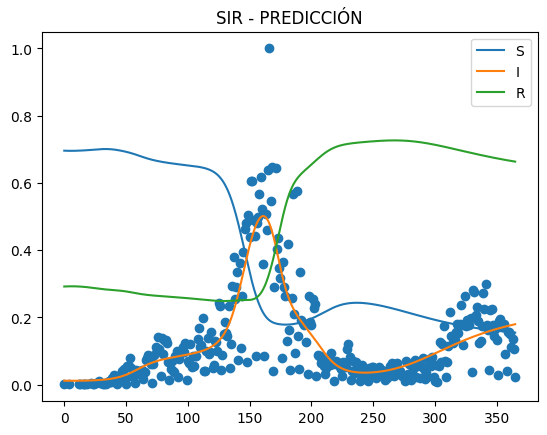

In [11]:

realSol = model(edoTL).detach().numpy()
TL = edoTL.detach().numpy()



plt.plot(TL, realSol[:, 0:1], label = "S")
plt.plot(TL, realSol[:, 1:2], label = "I")
plt.plot(TL, realSol[:, 2:3], label = "R")

#plt.scatter(days, incidents)

plt.legend()
plt.title("SIR - PREDICCIÓN")

plt.draw()